Copyright (c) 2008 Idiap Research Institute, http://www.idiap.ch/
    
Written by Suhan Shetty <suhan.shetty@idiap.ch>,


### Motion Planning without task-parameters

In [1]:
%load_ext autoreload
%autoreload 2
import torch
import numpy as np 
torch.set_default_tensor_type(torch.DoubleTensor)
from planar_manipulator import PlanarManipulator
from plot_utils import plot_chain

np.set_printoptions(3, suppress=True)
torch.set_printoptions(3, sci_mode=False)

import sys
sys.path.append('../')
from ttgo import TTGO
import tt_utils
from cost_utils import PlanarManipulatorCost
from utils import Point2PointMotion

import warnings
warnings.filterwarnings('ignore')


/idiap/temp/sshetty/miniconda/envs/pyml/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-q4z1awsf because the default path (/idiap/home/sshetty/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
print("Note: Choose cuda if you have enough memory")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

Note: Choose cuda if you have enough memory


device(type='cuda')

In [3]:
file_name = None # trained model

In [27]:
# Define the robot
n_joints = 4
link_lengths = torch.tensor([1.]*n_joints).to(device)
max_theta = torch.pi
min_theta = -1*max_theta
n_kp = 10;
dt = 0.01;
d0_w = 10;
# Define the environment and the task (Cost function)

x_obst = [torch.tensor([1.5,1.]).to(device) ,torch.tensor([1.6,2.1]).to(device) ,torch.tensor([3.0,0]).to(device) ,torch.tensor([2.,-0.5]).to(device) ]#,torch.tensor([0.5,0.])]
r_obst = [0.4,0.1,0.4,0.4]
margin=0.02
w_goal= 0.; w_obst=0.6; w_ee=0.; w_control=0.4;
b_goal=0.1;b_obst=1; b_ee=1; b_control=1.;

theta_0 = torch.tensor([ -0.05*np.pi, 0.55*np.pi, 0.45*np.pi, -0.45*np.pi]).to(device) #torch.tensor([2.1*torch.pi/4,-1.5*torch.pi/4]).view(1,-1)
theta_3 = torch.tensor([-np.pi*0.,   np.pi*0.1 ,  np.pi*0.3,  np.pi*0.1]).to(device) 

K=2
robot = PlanarManipulator(n_joints=n_joints,link_lengths=link_lengths,max_theta=max_theta,n_kp=n_kp, device=device)
bounds = [robot.min_config, robot.max_config]
p2p_motion = Point2PointMotion(n=n_joints,dt=dt,K=K,basis='rbf',bounds=bounds, device=device)
costPlanarManipulator = PlanarManipulatorCost(robot,p2p_motion=p2p_motion,x_obst=x_obst,r_obst=r_obst, margin=margin,
                                              w_goal=w_goal,w_obst=w_obst,w_ee=w_ee, w_control=w_control,
                                              b_goal=b_goal, b_obst=b_obst,b_ee=b_ee, b_control=b_control,
                                              device=device)

Define the domain and the cost functions

In [28]:
# Pick and place location (via-points: x_1 and x_2)
domain_w = [torch.linspace(min_theta,max_theta,d0_w).to(device)]*(K*n_joints)
def cost(x):
    return costPlanarManipulator.cost_j2j(x,theta_0,theta_3)[:,0]

def cost_to_print(x):
    return costPlanarManipulator.cost_j2j(x,theta_0,theta_3)

def pdf(x):
    return torch.exp(-cost(x)**2)


domain = domain_w


In [29]:

tt_model = tt_utils.cross_approximate(fcn=pdf,  domain=domain, 
                            rmax=200, nswp=2, eps=1e-3, verbose=True, 
                            kickrank=5, val_size=1, device=device)

cross device is cuda
Cross-approximation over a 8D domain containing 390625 grid points:
iter: 0 | tt-error: 1.000e+00, test-error:nan | time:   0.1158 | largest rank:   1
iter: 1 | tt-error: 1.446e+23, test-error:inf | time:   0.3233 | largest rank:   6 <- max_iter was reached: 2
Did 2190 function evaluations, which took 0.1617s (1.354e+04 evals/s)



In [30]:
# This step is not necessary but it will likely improve the quality of solution at little computation cost
# Refine the discretization and interpolate the model to have finer discretization
import tt_utils
tt_model_new, domain_new  =  tt_utils.refine_approximation(tt_model=tt_model.clone(),
                                                               domain=domain, 
                                                               site_list=torch.arange(len(domain)), 
                                                               scale_factor=10, device=device)

ttgo = TTGO(domain=[x.to(device) for x in domain_new], tt_model=tt_model_new.to(device), cost=cost, device=device)

## Visualization

In [63]:
# samples= ttgo.sample_random(n_samples=100)
samples = ttgo.sample_tt(n_samples=10,alpha=0.99)
state_tt_k = ttgo.choose_top_k_sample(samples,k=2)[0]

state_tt_opt_k = 1*state_tt_k
for i in range(state_tt_k.shape[0]):
    state_tt_opt_k[i,:], _ = ttgo.optimize(state_tt_k[i])
x = state_tt_opt_k#1*state_tt.reshape(1,-1)

costPlanarManipulator.cost_j2j(x,theta_0,theta_3)


tensor([[0.05, 0.00, 0.13],
        [0.15, 0.00, 0.37]], device='cuda:0')

In [64]:

batch_size = x.shape[0]
theta_1 = theta_0.repeat(batch_size,1)
theta_2 = theta_3.repeat(batch_size,1)
w = 1*x # weights
theta_t = p2p_motion.gen_traj_p2p(theta_1,theta_2,w) #joint angles: batch x time x joint
T = theta_t.shape[1]

key_loc_t,joint_loc_t, ee_loc_t, theta_ee_t = robot.forward_kin(theta_t.view(-1,n_joints)) # (batchxtime) x joint x key x positions
joint_loc_t = joint_loc_t.view(batch_size,-1,n_joints+1,2)
# joint_loc_t.shape

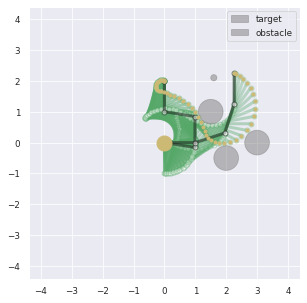

In [65]:
joint_loc = joint_loc_t[0].cpu()
x_obst_np = [x.cpu().numpy() for x in x_obst]
link_lengths_np = link_lengths.cpu().numpy()
plt=plot_chain(joint_loc=joint_loc, link_lengths=link_lengths_np, x_obst=x_obst_np, r_obst=r_obst, rect_patch=[], x_target=[], 
       batch=True, figsize=5, skip_frame=2, title=None, save_as=None, color_intensity=0.9, motion=True, alpha=0., 
           contrast=0.4, idx_highlight=[0,int(joint_loc.shape[0]-1)], lw=3, task='reaching')
plt.savefig("reach-2d-no-task-1.png",dpi=300, pad_inches=0.01,bbox_inches='tight' )